#### Week 10 Exercise 10.2 Author: Rex Gayas Course & Section: DSC320-T301 Math for Data Science (2243-1) Date: 18 February 2024

#### Summarizing Data

In [31]:
# Solution to 1(a).
import pandas as pd

# File Path of qb stats
file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Winter 2023\\Math for Data Science\\Week 10\\week10data\\week10data\\qb_stats.csv"

# Load the dataset
data = pd.read_csv(file_path)

# Calculate the mean of each numerical column
means = data.mean(numeric_only=True)

print("Means of each numerical column:")
print(means)


Means of each numerical column:
games         14.125000
att          478.406250
cmp          306.562500
comp_pct      64.296875
yds         3515.062500
ypa            7.375000
td            22.375000
int           10.343750
sack          32.312500
loss         217.093750
rating        93.387500
dtype: float64


In [32]:
# Solution to 1(b)
import pandas as pd

# File Path of qb stats
file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Winter 2023\\Math for Data Science\\Week 10\\week10data\\week10data\\qb_stats.csv"

# Load the dataset
data = pd.read_csv(file_path)

# Calculate the standard deviation of each numerical column
standard_deviations = data.std(numeric_only=True)

print("Standard deviation of each numerical column:")
print(standard_deviations)


Standard deviation of each numerical column:
games         2.406309
att         110.360366
cmp          68.929575
comp_pct      3.627537
yds         852.437489
ypa           0.796768
td            6.256609
int           5.839849
sack         10.514008
loss         70.786075
rating       11.054725
dtype: float64


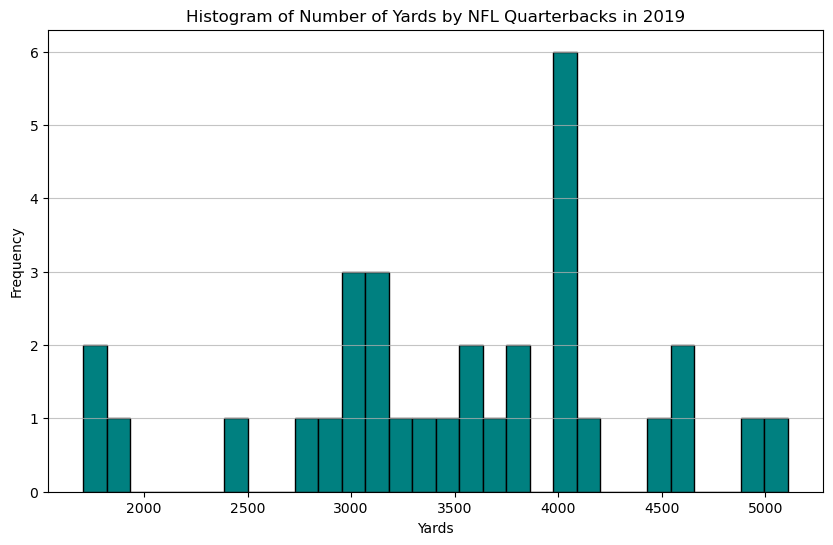

In [33]:
# Solution to 1(c)
import pandas as pd
import matplotlib.pyplot as plt

# File Path of qb stats
file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Winter 2023\\Math for Data Science\\Week 10\\week10data\\week10data\\qb_stats.csv"

# Load the dataset
data = pd.read_csv(file_path)

# Create a histogram of the number of yards
plt.figure(figsize=(10, 6))
plt.hist(data['yds'], bins=30, color='teal', edgecolor='black')
plt.title('Histogram of Number of Yards by NFL Quarterbacks in 2019')
plt.xlabel('Yards')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Display the histogram
plt.show()


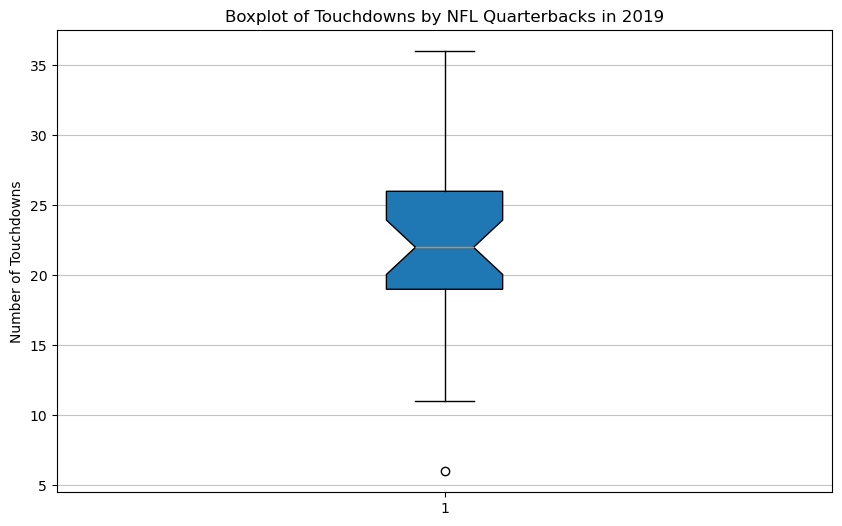

(None, [6.0])

In [34]:
# Solution to 1(d)
import pandas as pd
import matplotlib.pyplot as plt

# File Path of qb stats
file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Winter 2023\\Math for Data Science\\Week 10\\week10data\\week10data\\qb_stats.csv"

# Load the dataset
data = pd.read_csv(file_path)

# Create a boxplot of the number of touchdowns
plt.figure(figsize=(10, 6))
plt.boxplot(data['td'].dropna(), patch_artist=True, notch=True)
plt.title('Boxplot of Touchdowns by NFL Quarterbacks in 2019')
plt.ylabel('Number of Touchdowns')
plt.grid(axis='y', alpha=0.75)

# Identify outliers
Q1 = data['td'].quantile(0.25)
Q3 = data['td'].quantile(0.75)
IQR = Q3 - Q1
outliers = data[(data['td'] < (Q1 - 1.5 * IQR)) | (data['td'] > (Q3 + 1.5 * IQR))]['td']

# Display the boxplot and the outliers
plt.show(), outliers.tolist()


Outliers defined as observations that fall below Q1 - 1.5 IQR or above Q3 + 1.5 IQR.
Hence, boxplot shows there is at least one outlier identified, which is a value of 6 touchdowns. 

#### Calculating Probabilities from Data

In [35]:
# Solution to 2(a)
import pandas as pd

# Local file path
local_file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Winter 2023\\Math for Data Science\\Week 10\\week10data\\week10data\\survey_data.csv"

# Load the dataset
survey_data = pd.read_csv(local_file_path)

# Calculate the probability of a student having brown hair
total_students = survey_data.shape[0]
students_with_brown_hair = survey_data[survey_data['hair_color'].str.lower() == 'brown'].shape[0]
probability_brown_hair = students_with_brown_hair / total_students

# Print the probability as a percentage
probability_text = f"Probability of a college student having brown hair: {probability_brown_hair:.2%}"
probability_text

'Probability of a college student having brown hair: 51.23%'

In [36]:
# Solution to 2(b)
import pandas as pd

# Local file path
local_file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Winter 2023\\Math for Data Science\\Week 10\\week10data\\week10data\\survey_data.csv"

# Load the dataset
survey_data = pd.read_csv(local_file_path)

# Calculate the probability of a student having blue eyes
students_with_blue_eyes = survey_data[survey_data['eye_color'].str.lower() == 'blue'].shape[0]
probability_blue_eyes = students_with_blue_eyes / total_students

# Print the probability as a percentage
probability_blue_eyes_text = f"Probability of a college student having blue eyes: {probability_blue_eyes:.2%}"
probability_blue_eyes_text


'Probability of a college student having blue eyes: 24.69%'

In [37]:
# Solution to 2(c)
import pandas as pd

# Local file path
local_file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Winter 2023\\Math for Data Science\\Week 10\\week10data\\week10data\\survey_data.csv"

# Load the dataset
survey_data = pd.read_csv(local_file_path)

# Filter the dataset for students with brown hair
students_with_brown_hair = survey_data[survey_data['hair_color'].str.lower() == 'brown']

# Calculate the number of students with brown hair AND blue eyes
students_with_brown_hair_and_blue_eyes = students_with_brown_hair[students_with_brown_hair['eye_color'].str.lower() == 'blue'].shape[0]

# Calculate the conditional probability
probability_blue_eyes_given_brown_hair = students_with_brown_hair_and_blue_eyes / students_with_brown_hair.shape[0]

# Print the conditional probability as a percentage
print(f"Probability of a college student having blue eyes given they have brown hair: {probability_blue_eyes_given_brown_hair:.2%}")


Probability of a college student having blue eyes given they have brown hair: 21.69%


In [38]:
# Solution to 2(d)
#import pandas as pd

# Local file path
local_file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Winter 2023\\Math for Data Science\\Week 10\\week10data\\week10data\\survey_data.csv"

# Load the dataset
survey_data = pd.read_csv(local_file_path)

# Filter the dataset for students with blue eyes
students_with_blue_eyes = survey_data[survey_data['eye_color'].str.lower() == 'blue']

# Calculate the number of students with blue eyes AND brown hair
students_with_blue_eyes_and_brown_hair = students_with_blue_eyes[students_with_blue_eyes['hair_color'].str.lower() == 'brown'].shape[0]

# Calculate the conditional probability
probability_brown_hair_given_blue_eyes = students_with_blue_eyes_and_brown_hair / students_with_blue_eyes.shape[0]

# Print the conditional probability as a percentage
print(f"Probability of a college student having brown hair given they have blue eyes: {probability_brown_hair_given_blue_eyes:.2%}")



Probability of a college student having brown hair given they have blue eyes: 45.00%


Solution to 2(e). The probabilities calculated indicate that having brown hair and having blue eyes are not independent events for college students. This conclusion is drawn because the conditional probabilities differ from the overall probabilities, suggesting the occurrence of one trait affects the likelihood of the other. Specifically, the probability of having blue eyes given brown hair (21.69%) does not match the general probability of having blue eyes (24.69%), and similarly for brown hair given blue eyes (45.00%) versus the general probability of having brown hair (51.23%).

##### Bar Graph for Hair Color

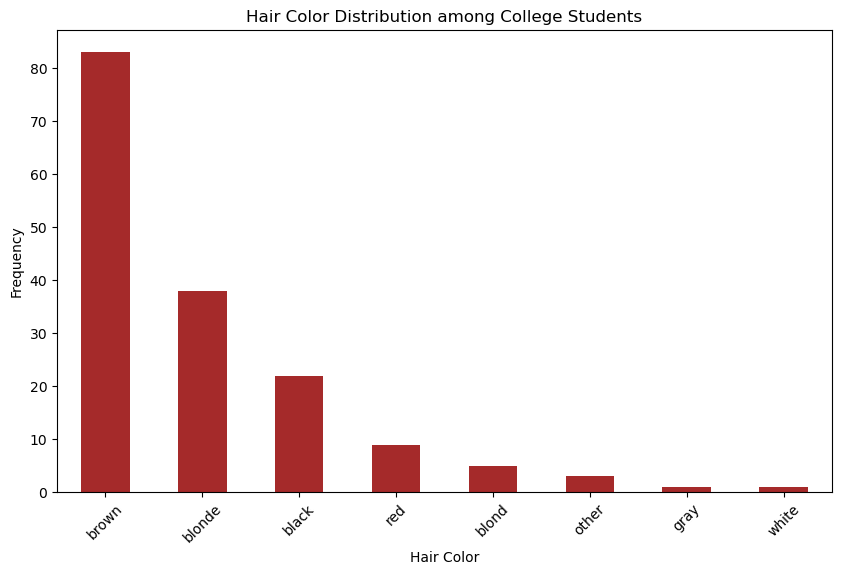

In [39]:
# Solution to 2(f)
import matplotlib.pyplot as plt

# Group the data by hair color and count the number of occurrences
hair_color_counts = survey_data['hair_color'].value_counts()

# Plotting the bar graph for hair color
plt.figure(figsize=(10, 6))
hair_color_counts.plot(kind='bar', color='brown')
plt.title('Hair Color Distribution among College Students')
plt.xlabel('Hair Color')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


##### Bar Graph for Eye Color

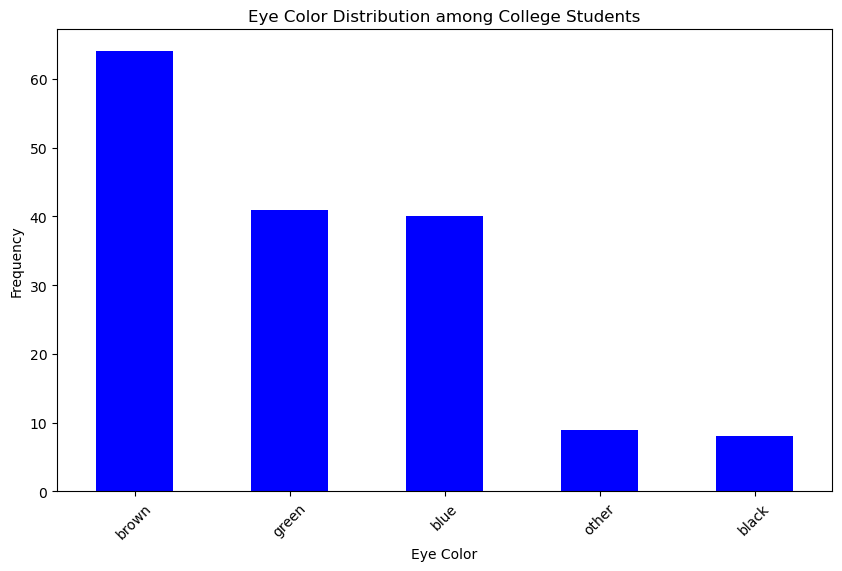

In [40]:
# Solution to 2(f)
import matplotlib.pyplot as plt

# Group the data by eye color and count the number of occurrences
eye_color_counts = survey_data['eye_color'].value_counts()

# Plotting the bar graph for eye color
plt.figure(figsize=(10, 6))
eye_color_counts.plot(kind='bar', color='blue')
plt.title('Eye Color Distribution among College Students')
plt.xlabel('Eye Color')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
